# Analysis

The policy paper outlines four different UBI levels, each with different net costs after UBI and tax-benefit changes. This response is in two main parts: the first, which simulates the reforms and evaluates the distributional impacts as well as poverty changes, and the second, which answers and provides evidence for the report's questions.

## Reform effects

### Funding breakdown

Below specifies the first reform, and calculates the effects of each component. This is a £45/week UBI for working-age adults, funded in part by including it in benefit means tests[^1], reducing the Personal Allowance for working-age adults and reducing the National Insurance Primary Threshold to £50/week. Overall, the Personal Allowance provides most of the funding, and the inclusion in means tested benefits provides only a small part that could be covered by reducing the personal allowance further.

[^1]: Universal Credit and the Tax Credits simulated.

In [1]:
from openfisca_uk import Microsimulation
from reform import WA_adult_UBI, include_UBI_in_means_tests, set_PA, set_PA_for_WA_adults, set_PT, net_cost
import numpy as np
import pandas as pd
from tqdm import trange, tqdm

ubi_45 = (WA_adult_UBI(45 * 52), include_UBI_in_means_tests(), set_PA_for_WA_adults(2500), set_PT(50))
baseline = Microsimulation()
ubi_45_sim = Microsimulation(ubi_45)

net_costs = []
names = ["UBI (£45/week)", "Reduced Benefits", "Lower PA", "Lower PT"]
for i in range(len(ubi_45) + 1):
    net_costs += [net_cost(baseline, Microsimulation(ubi_45[:i]))]
net_costs = np.array(net_costs)

resulting_costs = pd.Series((net_costs[1:] - net_costs[:-1]) / 1e+9).apply(lambda x: round(x, 1))

pd.DataFrame({"Component": names, "Net cost (£bn)": resulting_costs, "Resulting net cost (£bn)": resulting_costs.cumsum()}).set_index("Component")

,Net cost (£bn),Resulting net cost
Component,,
UBI (£45/week),93.6,93.6
Reduced Benefits,-6.0,87.6
Lower PA,-58.6,29.0
Lower PT,-37.2,-8.2


### UBI variants

The policy paper looks at four UBI proposals, characterized mainly by their UBI level: £45, £60, £75 and £95 per week. The below table shows the estimated cost of the reforms (as far as their funding methods can be implied from the paper[^2]). In all reforms except the smallest UBI, the estimated costs are within the ranges estimated by the paper. The wording of the paper implies that in at least some of the reforms, the tax changes are not as large, so it is plausible that the paper assigned a higher personal allowance in the smallest UBI policy, reducing its funding and therefore increasing its cost.

[^2]: The paper does not specify whether the tax changes are the same in each reform. Here, we have assumed that the PA and PT are reduced to £50/week for all reforms.

In [4]:
ubi_60 = (WA_adult_UBI(60 * 52), include_UBI_in_means_tests(), set_PA_for_WA_adults(2500), set_PT(50))
ubi_75 = (WA_adult_UBI(75 * 52), include_UBI_in_means_tests(), set_PA_for_WA_adults(2500), set_PT(50))
ubi_95 = (WA_adult_UBI(95 * 52), include_UBI_in_means_tests(), set_PA_for_WA_adults(2500), set_PT(50))

from openfisca_uk.api import *

def get_results(reform: Reform):
    sim = Microsimulation(reform)
    cost = net_cost(baseline, sim)
    baseline_poverty = baseline.calc("in_poverty_bhc", map_to="person").mean()
    poverty_change = (sim.calc("in_poverty_bhc", map_to="person").mean() - baseline_poverty) / baseline_poverty
    return sim, cost, poverty_change

reforms = (ubi_45, ubi_60, ubi_75, ubi_95)
names = ("£45", "£60", "£75", "£95")
results = list(map(get_results, reforms))
sims, costs, poverty_changes = list(zip(*results))
libdem_costings = (
    "13-18",
    "22-28",
    "48-56",
    "84-93"
)
pd.DataFrame({"UBI": names, "LD Net Cost (£bn)": libdem_costings, "Net cost (£bn)": pd.Series(costs).apply(lambda x: round(x / 1e+9, 1)), "Poverty change (%)": pd.Series(poverty_changes).apply(lambda x: round(x * 100, 1))}).set_index("UBI")

,LD Net Cost (£bn),Net cost (£bn),Poverty change (%)
UBI,,,
£45,13-18,-8.3,-16.1
£60,22-28,21.0,-26.8
£75,48-56,50.7,-35.5
£95,84-93,90.6,-45.6


### Distributional effects

The above effects only show the picture on the population as a whole. Below shows the average gain to members of the population by their household's equivalised disposable income.

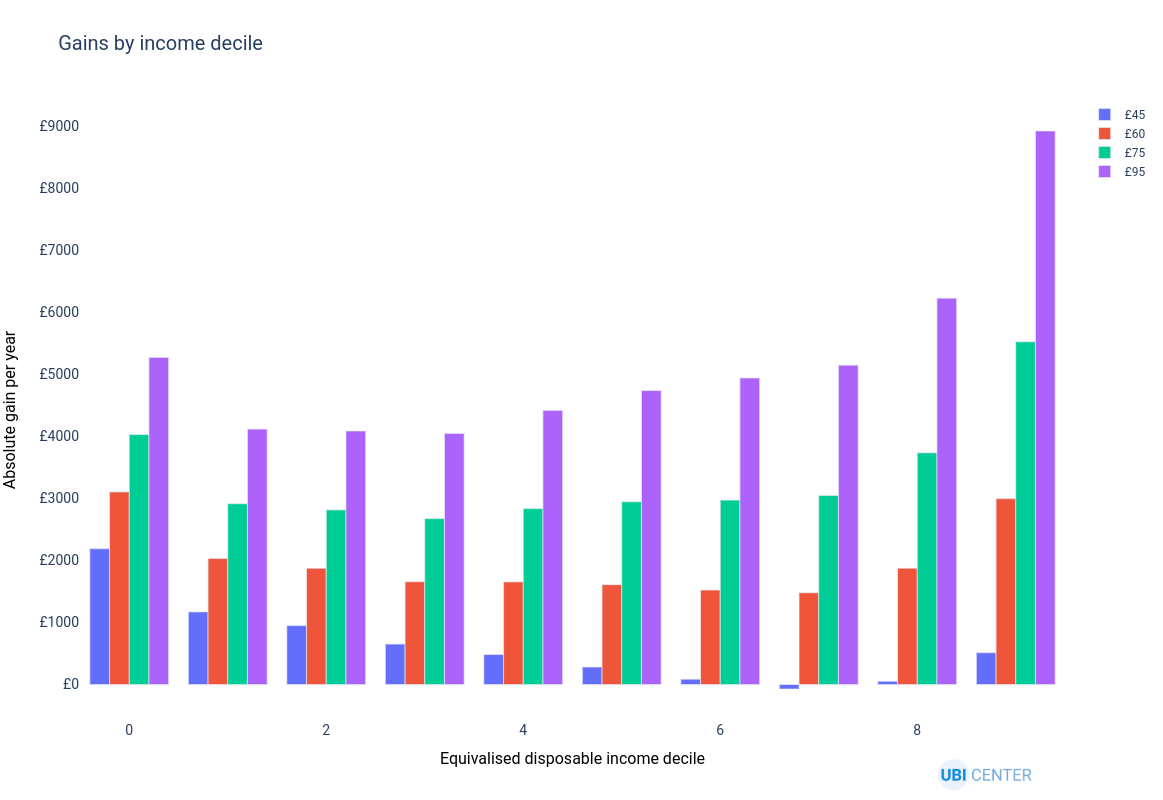

In [9]:
import plotly.graph_objects as go
from ubicenter import format_fig

fig = go.Figure()

income = baseline.calc("equiv_household_net_income", map_to="person")

for sim, name in zip(sims, names):
    gain = sim.calc("household_net_income", map_to="person") - baseline.calc("household_net_income", map_to="person")
    fig.add_trace(go.Bar(y=gain.groupby(income.decile_rank()).mean(), name=name))

format_fig(fig.update_layout(title="Gains by income decile", xaxis_title="Equivalised disposable income decile", yaxis_title="Absolute gain per year", yaxis_tickprefix="£"))